In [1]:
# importing packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.model_selection import train_test_split
from fbprophet import Prophet
import statsmodels.graphics.tsaplots as tsa_plots
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_excel('Stock_Returns_1931_2002.xlsx', sheet_name = "Sheet1")

/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
data.head()

,time,Month,ExReturn,ln_DivYield,Unnamed: 4
0,1931,1,5.964958,-282.232866,NaN
1,1931,2,10.305305,-293.208902,NaN
2,1931,3,-6.840831,-287.861414,NaN
3,1931,4,-10.448065,-278.247705,NaN
4,1931,5,-14.358077,-265.474152,NaN


In [4]:
data = data.drop(columns = "Unnamed: 4")

In [5]:
data.head()

,time,Month,ExReturn,ln_DivYield
0,1931,1,5.964958,-282.232866
1,1931,2,10.305305,-293.208902
2,1931,3,-6.840831,-287.861414
3,1931,4,-10.448065,-278.247705
4,1931,5,-14.358077,-265.474152


In [6]:
data.shape

(864, 4)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         864 non-null    int64  
 1   Month        864 non-null    int64  
 2   ExReturn     864 non-null    float64
 3   ln_DivYield  864 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 27.1 KB


In [8]:
data.describe()

,time,Month,ExReturn,ln_DivYield
count,864.000000,864.000000,864.000000,864.000000
mean,1966.500000,6.500000,0.502132,-327.675076
std,20.794642,3.454052,5.377249,37.803427
min,1931.000000,1.000000,-34.258389,-423.430865
25%,1948.750000,3.750000,-2.103179,-351.060408
50%,1966.500000,6.500000,0.895111,-325.713433
75%,1984.250000,9.250000,3.586565,-302.894296
max,2002.000000,12.000000,32.307310,-201.761748


In [9]:
data.isnull().sum()

time           0
Month          0
ExReturn       0
ln_DivYield    0
dtype: int64

In [10]:
data['Date'] = pd.to_datetime(data['time'].astype(str) + data['Month'].astype(str), format='%Y%m')

In [11]:
normaldata = data[:]
data.head()

,time,Month,ExReturn,ln_DivYield,Date
0,1931,1,5.964958,-282.232866,1931-01-01
1,1931,2,10.305305,-293.208902,1931-02-01
2,1931,3,-6.840831,-287.861414,1931-03-01
3,1931,4,-10.448065,-278.247705,1931-04-01
4,1931,5,-14.358077,-265.474152,1931-05-01


<AxesSubplot:xlabel='Date'>

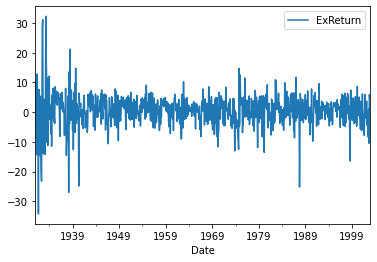

In [12]:
data.plot(x = 'Date', y = 'ExReturn')

## Let’s first plot AutoCorelation Function(ACF) and PartialAutoCorelation Function (PACF) using statsmodel library:

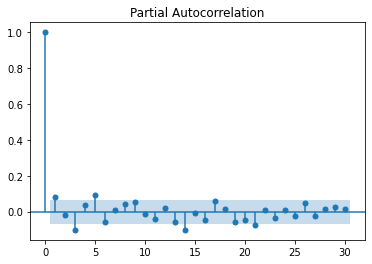

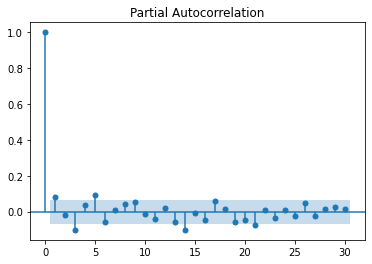

In [13]:
tsa_plots.plot_pacf(data['ExReturn'])

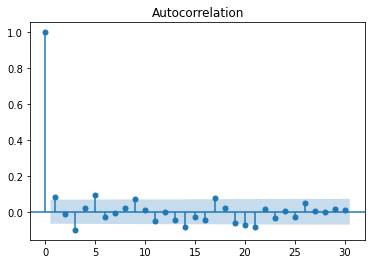

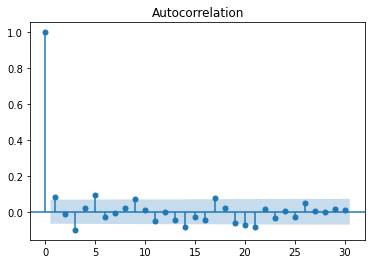

In [14]:
tsa_plots.plot_acf(data['ExReturn']) 

# P=1,Q=1

## Decomposing components

<ipython-input-15-9a1a141e068b>:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  fig = seasonal.seasonal_decompose(data['ExReturn'], freq=10, model='additive').plot()


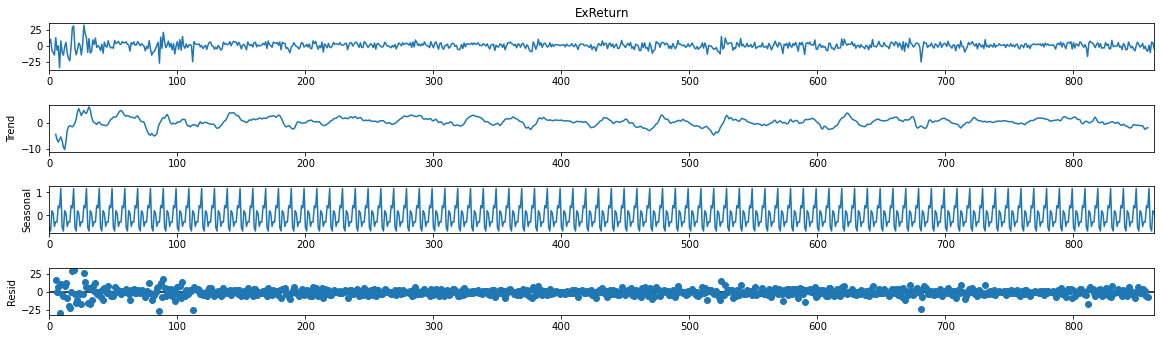

In [15]:
import statsmodels.tsa.seasonal as seasonal
import matplotlib.pyplot as plt

fig = seasonal.seasonal_decompose(data['ExReturn'], freq=10, model='additive').plot()
fig.set_figheight(5)
fig.set_figwidth(18)
plt.show()

 #We can see that there is no specific trend (upward/downward) of the percentage_change_next_weeks_price variable. But seasonal plot reveals the existence of seasonal components as it shows waves of ups & downs.

## Stationarity check — ADF test

In [16]:
result = adfuller(data['ExReturn'], autolag = 'AIC')

In [17]:
result

(-8.000838207693754,
 2.336368822902914e-12,
 20,
 843,
 {'1%': -3.438130930004224,
  '5%': -2.864974613145216,
  '10%': -2.568598863756932},
 5022.115339145178)

In [18]:
if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")

Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [19]:
Y = data['ExReturn']
X = data.drop(columns=['ExReturn','ln_DivYield'], axis=1)


In [20]:
X = X.set_index(['Date'])
X

,time,Month
Date,,
1931-01-01,1931,1
1931-02-01,1931,2
1931-03-01,1931,3
1931-04-01,1931,4
1931-05-01,1931,5
...,...,...
2002-08-01,2002,8
2002-09-01,2002,9
2002-10-01,2002,10


In [21]:
#TimeSeriesSplit incrementally splits the data in a cross-validation manner. We have to use the last X_train, X_test set.
tss = TimeSeriesSplit()
for train_index, test_index in tss.split(X,Y):
  Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index] 
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]

# Auto Modelling

In [22]:
auto_model = auto_arima(Y_train.to_numpy(), exogenous=X_train.to_numpy(), m=12, seasonal=True,
                        suppress_warnings = True,  
                        step_wise=True, trace=True)           
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4553.512, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4538.961, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4536.538, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4537.292, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4536.969, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4534.473, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4537.239, Time=0.41 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=4539.290, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=4536.295, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=4536.667, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=4534.487, Time=0.14 sec


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=4545.266, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=4532.471, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12]             : AIC=4534.537, Time=0.34 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=4535.239, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[12]             : AIC=4537.289, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=4534.292, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[12]             : AIC=4534.676, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=4532.485, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[12]             : AIC=4543.264, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12]          
Total fit time: 5.116 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2262.235
Date:                Sun, 27 Mar 2022   AIC                           4532.471
Time:                        18:47:21   BIC                           4550.788
Sample:                             0   HQIC                          4539.542
                                - 720                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002      0.000      0.867      0.386      -0.000       0.001
x2             0.0077      0.071      0.108      0.914      -0.132       0.148
ar.L1          0.0947      0.022      4.329      0.000       0.052       0.138
sigma2        31.3795      0.804     39.053      0.000      29.805      32.954
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1455.09
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
model = SARIMAX(endog=Y_train.to_numpy(), exog=X_train.to_numpy().astype(float), 
                order=(1, 0, 0),seasonal_order=(0, 0, 0, 12))
model = model.fit(disp=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  720
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2262.235
Date:                Sun, 27 Mar 2022   AIC                           4532.471
Time:                        18:47:21   BIC                           4550.788
Sample:                             0   HQIC                          4539.542
                                - 720                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002      0.000      0.867      0.386      -0.000       0.001
x2             0.0077      0.071      0.108      0.914      -0.132       0.148
ar.L1          0.0947      0.022      4.329      0.000       0.052       0.138
sigma2        31.3795      0.804     39.053      0.000      29.805      32.954
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1455.09
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# To test the model:

In [24]:
result = model.predict(start=1, end=144, exog=X_test.to_numpy().astype(float))

In [25]:
len(X_test), len(Y_test), len(result), len(X_train)

(144, 144, 144, 720)

In [26]:
from sklearn.metrics import mean_squared_error
mean_squared_error(result, Y_test)

16.12328658518381

# plotting actual vs predicted results.

<AxesSubplot:>

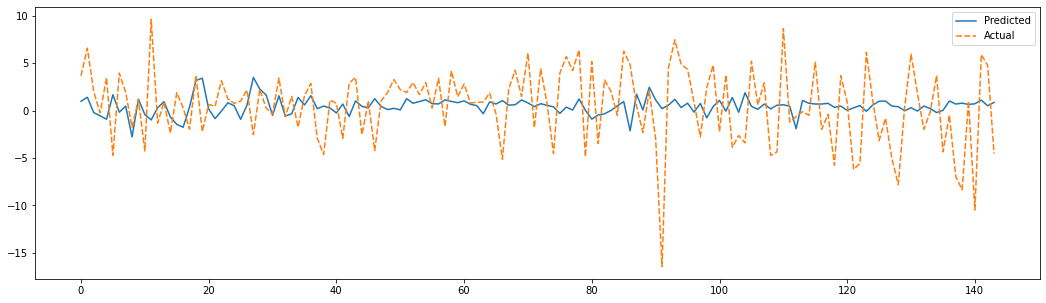

In [27]:
import seaborn as sns

plt.figure(figsize=(18,5))
sns.lineplot(data=pd.DataFrame({'Predicted':result,'Actual':Y_test.to_numpy()}))

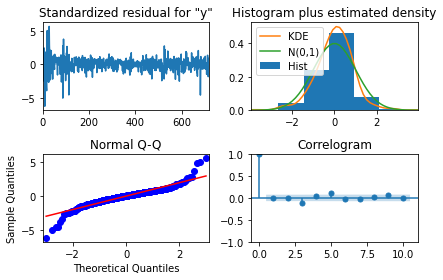

In [28]:
 #error distribution.

model.plot_diagnostics()
plt.tight_layout()
plt.show()

## Model 2 with dividend

In [29]:
data=data.set_index(['Date'])

In [30]:
data

,time,Month,ExReturn,ln_DivYield
Date,,,,
1931-01-01,1931,1,5.964958,-282.232866
1931-02-01,1931,2,10.305305,-293.208902
1931-03-01,1931,3,-6.840831,-287.861414
1931-04-01,1931,4,-10.448065,-278.247705
1931-05-01,1931,5,-14.358077,-265.474152
...,...,...,...,...
2002-08-01,2002,8,1.005623,-394.593048
2002-09-01,2002,9,-10.463990,-383.587520
2002-10-01,2002,10,5.908229,-388.606290


<AxesSubplot:xlabel='Date'>

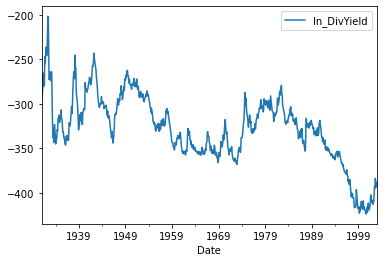

In [31]:
data.reset_index().plot(x ='Date', y = 'ln_DivYield')

In [32]:
result = adfuller(data['ln_DivYield'], autolag = 'AIC')

In [33]:
result

(-1.5305556978598003,
 0.5183453850599905,
 21,
 842,
 {'1%': -3.4381401994155976,
  '5%': -2.864978699501589,
  '10%': -2.568601040504172},
 5112.586325199529)

In [34]:
if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")

Weak evidence against null hypothesis, time series is non-stationary 


In [35]:
data = data.fillna(method='ffill')

In [36]:
data['ln_DivYield']=data['ln_DivYield'].diff()

In [37]:
data.dropna(inplace=True)

In [38]:
data['ln_DivYield'].isnull()

Date
1931-02-01    False
1931-03-01    False
1931-04-01    False
1931-05-01    False
1931-06-01    False
              ...  
2002-08-01    False
2002-09-01    False
2002-10-01    False
2002-11-01    False
2002-12-01    False
Name: ln_DivYield, Length: 863, dtype: bool

In [39]:
result1 = adfuller(data['ln_DivYield'], autolag = 'AIC')

In [40]:
result1

(-8.641892345889866,
 5.398031340136409e-14,
 20,
 842,
 {'1%': -3.4381401994155976,
  '5%': -2.864978699501589,
  '10%': -2.568601040504172},
 5103.60262890998)

In [41]:
if result1[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")

Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<AxesSubplot:xlabel='Date'>

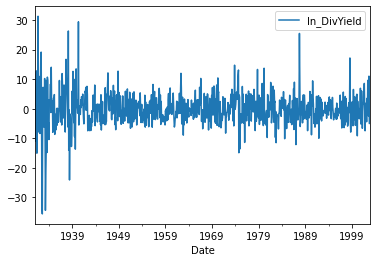

In [42]:
data.reset_index().plot(x ='Date', y = 'ln_DivYield')

In [43]:
data.head()

,time,Month,ExReturn,ln_DivYield
Date,,,,
1931-02-01,1931,2,10.305305,-10.976037
1931-03-01,1931,3,-6.840831,5.347489
1931-04-01,1931,4,-10.448065,9.613708
1931-05-01,1931,5,-14.358077,12.773554
1931-06-01,1931,6,12.850261,-15.036096


In [44]:
Y_div = data['ExReturn']
X_div = data.drop(columns=['ExReturn'], axis=1)

In [45]:
X_div

,time,Month,ln_DivYield
Date,,,
1931-02-01,1931,2,-10.976037
1931-03-01,1931,3,5.347489
1931-04-01,1931,4,9.613708
1931-05-01,1931,5,12.773554
1931-06-01,1931,6,-15.036096
...,...,...,...
2002-08-01,2002,8,-2.520499
2002-09-01,2002,9,11.005529
2002-10-01,2002,10,-5.018771


In [46]:
tss_div = TimeSeriesSplit()
for train_index_div, test_index_div in tss_div.split(X_div,Y_div):
  Y_train_div, Y_test_div = Y_div.iloc[train_index_div], Y_div.iloc[test_index_div] 
  X_train_div, X_test_div = X_div.iloc[train_index_div], X_div.iloc[test_index_div]

In [47]:
auto_model_div = auto_arima(Y_train_div.to_numpy(), exogenous=X_train_div.to_numpy(), m=12, seasonal=True,
                        suppress_warnings = True,  
                        step_wise=True, trace=True)           
auto_model_div.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2711.016, Time=2.23 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2857.025, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2813.543, Time=0.59 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2830.077, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2855.132, Time=0.33 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=2707.234, Time=1.86 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=2709.409, Time=0.71 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=2710.565, Time=5.73 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=2707.925, Time=2.13 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=2720.262, Time=4.39 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=2728.159, Time=1.25 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=2898.283, Time=1.26 sec
 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=2634.617, Time=2.13 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=2650.345, Time=0.47 sec
 ARIMA(3,0,2)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  720
Model:             SARIMAX(5, 0, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -1265.374
Date:                                 Sun, 27 Mar 2022   AIC                           2558.749
Time:                                         18:50:25   BIC                           2622.858
Sample:                                              0   HQIC                          2583.499
                                                 - 720                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002      0.000      1.597      0.110   -3.68e-05       0.000
x2             0.0176      0.009      2.026      0.043       0.001       0.035
x3            -0.9608      0.007   -129.371      0.000      -0.975      -0.946
ar.L1         -0.1704      0.114     -1.494      0.135      -0.394       0.053
ar.L2         -0.1481      0.139     -1.069      0.285      -0.420       0.123
ar.L3          0.8757      0.026     33.331      0.000       0.824       0.927
ar.L4          0.1310      0.082      1.593      0.111      -0.030       0.292
ar.L5          0.1120      0.097      1.157      0.247      -0.078       0.302
ma.L1          0.2634      0.110      2.394      0.017       0.048       0.479
ma.L2          0.2381      0.136      1.750      0.080      -0.029       0.505
ma.L3         -0.4564      0.046     -9.960      0.000      -0.546      -0.367
ma.S.L12      -0.3376      0.021    -16.444      0.000      -0.378      -0.297
ma.S.L24      -0.1646      0.020     -8.041      0.000      -0.205      -0.125
sigma2         1.9666      0.052     37.976      0.000       1.865       2.068
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):              6295.32
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
model_div = SARIMAX(endog=Y_train_div.to_numpy(), exog=X_train_div.to_numpy().astype(float), 
                order=(5, 0, 3),seasonal_order=(0, 0, 2, 12))
model_div = model_div.fit(disp=False)
model_div.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  720
Model:             SARIMAX(5, 0, 3)x(0, 0, [1, 2], 12)   Log Likelihood               -1265.374
Date:                                 Sun, 27 Mar 2022   AIC                           2558.749
Time:                                         18:50:34   BIC                           2622.858
Sample:                                              0   HQIC                          2583.499
                                                 - 720                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002      0.000      1.597      0.110   -3.68e-05       0.000
x2             0.0176      0.009      2.026      0.043       0.001       0.035
x3            -0.9608      0.007   -129.371      0.000      -0.975      -0.946
ar.L1         -0.1704      0.114     -1.494      0.135      -0.394       0.053
ar.L2         -0.1481      0.139     -1.069      0.285      -0.420       0.123
ar.L3          0.8757      0.026     33.331      0.000       0.824       0.927
ar.L4          0.1310      0.082      1.593      0.111      -0.030       0.292
ar.L5          0.1120      0.097      1.157      0.247      -0.078       0.302
ma.L1          0.2634      0.110      2.394      0.017       0.048       0.479
ma.L2          0.2381      0.136      1.750      0.080      -0.029       0.505
ma.L3         -0.4564      0.046     -9.960      0.000      -0.546      -0.367
ma.S.L12      -0.3376      0.021    -16.444      0.000      -0.378      -0.297
ma.S.L24      -0.1646      0.020     -8.041      0.000      -0.205      -0.125
sigma2         1.9666      0.052     37.976      0.000       1.865       2.068
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):              6295.32
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
result_div = model_div.predict(start=1, end=143, exog=X_test_div.to_numpy().astype(float))

In [50]:
len(X_test_div), len(Y_test_div), len(result_div), len(X_train_div)

(143, 143, 143, 720)

In [51]:
mean_squared_error(result_div, Y_test_div)

96.9005947357068

<AxesSubplot:>

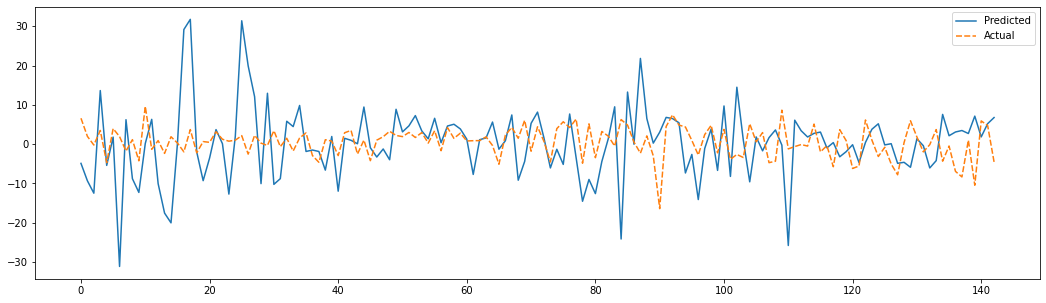

In [52]:
plt.figure(figsize=(18,5))
sns.lineplot(data=pd.DataFrame({'Predicted':result_div,'Actual':Y_test_div.to_numpy()}))

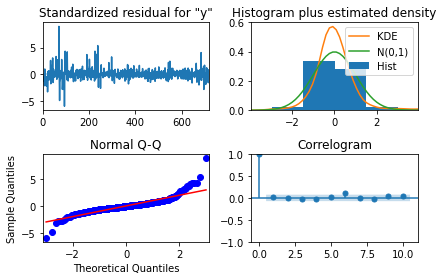

In [53]:
 #error distribution.

model_div.plot_diagnostics()
plt.tight_layout()
plt.show()

## Prophet Method using raw data

In [54]:
normaldata.rename(columns={'ExReturn': 'y', 'Date': 'ds'}, inplace=True)

train1 = normaldata[:691]
valid1 = normaldata[691:]

#fit the model
model = Prophet()
model.fit(train1)

#predictions
close_prices1 = model.make_future_dataframe(periods=len(valid1))
forecast1 = model.predict(close_prices1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
#rmse
forecast_valid1 = forecast1['yhat'][691:]
rms1=np.sqrt(np.mean(np.power((np.array(valid1['y'])-np.array(forecast_valid1)),2)))
rms1

4.146295790996689

<ipython-input-57-12d8164919a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid1['Predictions'] = 0
<ipython-input-57-12d8164919a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid1['Predictions'] = forecast_valid1.values


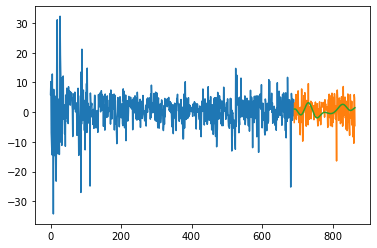

In [57]:
#plot
valid1['Predictions'] = 0
valid1['Predictions'] = forecast_valid1.values

plt.plot(train1['y'])
plt.plot(valid1[['y', 'Predictions']])

## Prophet Method using preprocessed data

In [58]:
data.reset_index(inplace=True)

In [59]:
logdata = data[:]

logdata.rename(columns={'ExReturn': 'y', 'Date': 'ds'}, inplace=True)

train1 = logdata[:691]
valid1 = logdata[691:]

#fit the model
model = Prophet()
model.fit(train1)

#predictions
close_prices1 = model.make_future_dataframe(periods=len(valid1))
forecast1 = model.predict(close_prices1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [60]:
#rmse
forecast_valid1 = forecast1['yhat'][691:]
rms1=np.sqrt(np.mean(np.power((np.array(valid1['y'])-np.array(forecast_valid1)),2)))
rms1

4.280829728010346

<ipython-input-61-12d8164919a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid1['Predictions'] = 0
<ipython-input-61-12d8164919a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid1['Predictions'] = forecast_valid1.values


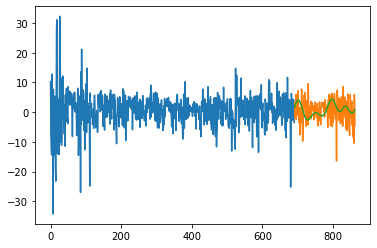

In [61]:
#plot
valid1['Predictions'] = 0
valid1['Predictions'] = forecast_valid1.values

plt.plot(train1['y'])
plt.plot(valid1[['y', 'Predictions']])